In [15]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from typing import List


In [16]:
import pandas as pd
import torch

df_train = pd.read_csv('./sign_mnist_train.csv')
df_test = pd.read_csv("./sign_mnist_test.csv")

X_train, y_train = df_train.iloc[:,1:].values/255.0, df_train.iloc[:,0].values #normalizing takes place here
X_test, y_test = df_test.iloc[:,1:].values/255.0, df_test.iloc[:,0].values

value_counts = {value: np.count_nonzero(y_train == value) for value in range(-1, 31)}

print(value_counts)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #One hot encoding of the labels
# y_train = lb.fit_transform(y_train)
# y_test = lb.fit_transform(y_test)

print("X_train numpy shape: "+ str(X_train.shape))
print("X_test numpy shape: " +str(X_test.shape))
print("y_train numpy shape: " +str(y_train.shape))
print("y_test numpy shape: " + str(y_test.shape))


X_train_tensor, y_train_tensor = torch.tensor(X_train).reshape(-1, 28, 28, 1), torch.tensor(y_train) #Reshaped to 2D images for the CNN
X_test_tensor, y_test_tensor = torch.tensor(X_test).reshape(-1,28,28,1), torch.tensor(y_test)

print("X_train tensor shape: "+ str(X_train_tensor.shape))
print("X_test tensor shape: " +str(X_test_tensor.shape))
print("y_train tensor shape: " +str(y_train_tensor.shape))
print("y_test tensor shape: " + str(y_test_tensor.shape))


{-1: 0, 0: 1126, 1: 1010, 2: 1144, 3: 1196, 4: 957, 5: 1204, 6: 1090, 7: 1013, 8: 1162, 9: 0, 10: 1114, 11: 1241, 12: 1055, 13: 1151, 14: 1196, 15: 1088, 16: 1279, 17: 1294, 18: 1199, 19: 1186, 20: 1161, 21: 1082, 22: 1225, 23: 1164, 24: 1118, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0}
X_train numpy shape: (27455, 784)
X_test numpy shape: (7172, 784)
y_train numpy shape: (27455,)
y_test numpy shape: (7172,)
X_train tensor shape: torch.Size([27455, 28, 28, 1])
X_test tensor shape: torch.Size([7172, 28, 28, 1])
y_train tensor shape: torch.Size([27455])
y_test tensor shape: torch.Size([7172])


In [17]:
def evaluate_accuracy(y_true, predicted_probabilities):
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    correct_predictions = predicted_classes == y_true
    accuracy = np.mean(correct_predictions) 
    return accuracy

In [18]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError
    

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)
    
    def get_params(self):
        return self.w.copy(), self.b.copy()
    
    def set_params(self, w :np.ndarray, b:np.ndarray):
        self.w = w.copy()
        self.b = b.copy()
    

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient
    
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        # Shift x by subtracting its max value from each vector in the batch
        shift_x = x - np.max(x, axis=-1, keepdims=True)
        exps = np.exp(shift_x)
        probs = exps / np.sum(exps, axis=-1, keepdims=True)
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [19]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def get_params(self):
        # Collect parameters from all layers that have them
        params = []
        for layer in self.layers:
            if hasattr(layer, 'get_params'):
                params.extend(layer.get_params())
        return params

    def apply_params(self, parameters):
        # Apply parameters to all layers that have them
        param_iter = iter(parameters)
        for layer in self.layers:
            if hasattr(layer, 'set_params'):
                layer.set_params(next(param_iter), next(param_iter))
            

In [20]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            g_avg = g.mean(axis=0)
            p -= self.lr * g_avg


class GradientDescentOptimizerWithSchedule(GradientDescentOptimizer):
    def __init__(self, net: MLP, lr: float, schedule_step: int, decay_factor: float):
        super().__init__(net, lr)
        self.schedule_step = schedule_step
        self.decay_factor = decay_factor
        self.current_step = 0

    def step(self):
        super().step()
        self.current_step += 1
        if self.current_step % self.schedule_step == 0:
            self.update_lr()

    def update_lr(self):
        self.lr *= self.decay_factor
        print(f"Updated learning rate to {self.lr}")





In [21]:
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps, batch_size=128, patience =250):

    #First split into train/validation split
    np.random.seed(13) #So that its deterministic
    val_size = int(len(data_x) * 0.2)  # For an 80/20 split
    indices = np.arange(len(data_x))
    np.random.shuffle(indices)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    # Use the indices to create training and validation sets
    x_train, y_train = data_x[train_indices], data_y[train_indices]
    x_val, y_val = data_x[val_indices], data_y[val_indices]

    losses = []

    #Validation stuff
    val_losses = [10e10]
    n_samples = x_train.shape[0]
    labels_train = np.eye(25)[np.array(y_train)]  # One-hot encode labels
    labels_val = np.eye(25)[np.array(y_val)]
    val_every_ith_epoch = 250
    best_params = None

    #Early stoping stuff
    best_loss = float('inf')
    no_improvement_count = 0

    for i in tqdm(range(steps)):
        # Randomly select batch indices for each step
        batch_indices = np.random.choice(n_samples, batch_size, replace=False)
        batch_x = x_train[batch_indices]
        labels = labels_train[batch_indices]

        predictions = mlp.forward(batch_x)
        
        loss = -(labels * np.log(predictions+1e-9)).sum(axis=-1).mean()
        losses.append(loss)
        
        mlp.backward(labels)
        optimizer.step()

        #Early Stopping check
        if len(losses) > 2 * patience:  # Ensure there are enough points to compare
            recent_avg_loss = np.mean(losses[-patience:])
            prev_avg_loss = np.mean(losses[-2*patience:-patience])
            if recent_avg_loss < best_loss:
                best_loss = recent_avg_loss
                no_improvement_count = 0  # Reset the counter as we found a better loss
            elif recent_avg_loss >= prev_avg_loss: #no improvement
                no_improvement_count += 1
            else:
                no_improvement_count = 0  # Safeguard

            if no_improvement_count >= patience:
                print(f"Early stopping at step {i}: no improvement in the last {patience} checks.")
                break  # Stop training if no improvement for 'patience' consecutive checks

        #Validation check
        if (i % val_every_ith_epoch == 0):
            val_batch_size = 64
            batch_val_losses = []
            
            # Iterate over the validation set in mini-batches
            for j in range(0, len(x_val), val_batch_size):
                x_val_batch = x_val[j:j + val_batch_size]
                y_val_batch = labels_val[j:j + val_batch_size]
                
                predictions_val_batch = mlp.forward(x_val_batch)
                
                # Compute loss for the validation batch
                loss_val_batch = -(y_val_batch * np.log(predictions_val_batch + 1e-9)).sum(axis=-1).mean()
                batch_val_losses.append(loss_val_batch)
            
            # Calculate the average validation loss over all mini-batches
            loss_val = np.mean(batch_val_losses)

            if loss_val < np.min(val_losses):
                best_params = mlp.get_params()
            val_losses.extend([loss_val] * val_every_ith_epoch) #Straight line extension

    plt.plot(losses, label='Training Loss', linestyle='-', color='blue')
    plt.plot(val_losses[1:], label='Validation Loss', linestyle='--', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.yscale("log")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()
    

    return best_params

In [22]:
def get_accuracy_stats(mlp :MLP, best_params_no_val, best_params_val, X_test, y_test, X_train, y_train):
    mlp.apply_params(best_params_no_val)
    accuracy_no_val_train = evaluate_accuracy(y_train, mlp.forward(X_train))*100
    accuracy_no_val_test = evaluate_accuracy(y_test, mlp.forward(X_test))*100

    mlp.apply_params(best_params_val)
    accuracy_val_train = evaluate_accuracy(y_train, mlp.forward(X_train))*100
    accuracy_val_test = evaluate_accuracy(y_test, mlp.forward(X_test))*100

    print(f"Train accuracy no validation = {accuracy_no_val_train:.2f}%")
    print(f"Test accuracy no validation = {accuracy_no_val_test:.2f}%")
    print(f"Train accuracy with validation = {accuracy_val_train:.2f}%")
    print(f"Test accuracy with validation = {accuracy_val_test:.2f}%")
    return accuracy_no_val_train,accuracy_no_val_test,accuracy_val_train, accuracy_val_test


<h1>Task 3.1</h1>

<h3> No hidden layer </h3>

In [ ]:
mlp_no_hidden_layer = MLP(
    LinearLayer(784, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_no_hidden_layer, 1e-1)
gradient_steps = 10000
best_val_params = train(mlp_no_hidden_layer, optimizer, X_train, y_train, gradient_steps)
best_no_val_params = mlp_no_hidden_layer.get_params()


In [ ]:
print("NO HIDDEN LAYER")
no_hidden_layer_stats = get_accuracy_stats(mlp_no_hidden_layer, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
print("\n\n\n\n")

<h3> One Hidden Layer </h3>

In [ ]:
#Hyperparameter optimization
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (256,)],  # Single layer with varying sizes
    'learning_rate_init': [0.001, 0.01, 0.1, 1]
}

#No regularization alpha = 0.0
scimlp = MLPClassifier(activation='relu', solver='sgd', alpha=0.0, batch_size=128, max_iter=1000)
grid_search = GridSearchCV(scimlp, param_grid, cv=5, verbose=2)  #cv is K-fold cross validation, verbose is amount of detail printed to console
grid_search.fit(X_train, y_train)




In [ ]:
HIDDEN_UNITS = 32
mlp_one_hidden_layer_32 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_32, 1e-1)
gradient_steps = 10000
best_val_params_32 = train(mlp_one_hidden_layer_32, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_32 = mlp_one_hidden_layer_32.get_params()


In [ ]:
print("ONE HIDDEN LAYER 32")
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_32, best_no_val_params_32, best_val_params_32, X_test, y_test, X_train, y_train)


In [ ]:
HIDDEN_UNITS = 64
mlp_one_hidden_layer_64 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_64, 1e-1)
gradient_steps = 10000
best_val_params_64 = train(mlp_one_hidden_layer_64, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_64 = mlp_one_hidden_layer_64.get_params()

In [ ]:
print("ONE HIDDEN LAYER 64")
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_64, best_no_val_params_64, best_val_params_64, X_test, y_test, X_train, y_train)


 20%|█▉        | 1998/10000 [02:04<07:13, 18.48it/s] 

Updated learning rate to 0.09000000000000001


 40%|████      | 4000/10000 [04:04<05:04, 19.73it/s]

Updated learning rate to 0.08100000000000002


 60%|█████▉    | 5998/10000 [05:42<02:46, 24.06it/s]

Updated learning rate to 0.07290000000000002


 80%|████████  | 8000/10000 [07:09<01:20, 24.82it/s]

Updated learning rate to 0.06561000000000002


100%|██████████| 10000/10000 [08:40<00:00, 19.21it/s]


Updated learning rate to 0.05904900000000002


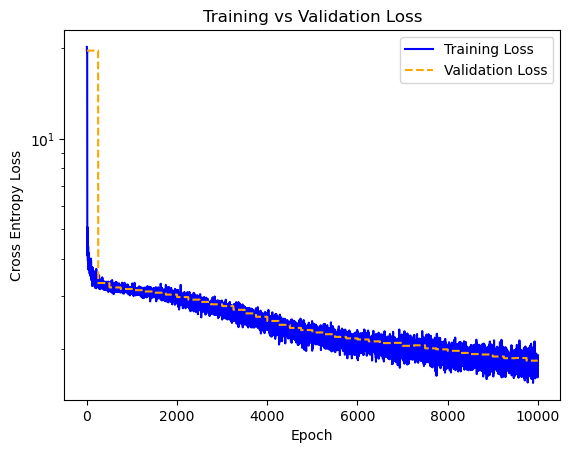

In [23]:
HIDDEN_UNITS = 128
mlp_one_hidden_layer_128 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
# optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_128, 1e-1)
optimizer = GradientDescentOptimizerWithSchedule(mlp_one_hidden_layer_128, lr= 0.1, schedule_step=2000, decay_factor=0.9 )
gradient_steps = 10000
best_val_params_128 = train(mlp_one_hidden_layer_128, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_128 = mlp_one_hidden_layer_128.get_params()

In [ ]:
#Trying to train another 10000 epochs -> highlights the convergence problem we're seeing
gradient_steps = 10000
best_val_params_128 = train(mlp_one_hidden_layer_128, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_128 = mlp_one_hidden_layer_128.get_params()

In [24]:
print("ONE HIDDEN LAYER 128")
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_128, best_no_val_params_128, best_val_params_128, X_test, y_test, X_train, y_train)


ONE HIDDEN LAYER 128
Train accuracy no validation = 36.84%
Test accuracy no validation = 26.27%
Train accuracy with validation = 36.69%
Test accuracy with validation = 25.00%


In [ ]:
HIDDEN_UNITS = 256
mlp_one_hidden_layer_256 = MLP(
    LinearLayer(784, HIDDEN_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_UNITS, 25),
    SoftmaxOutputLayer()
)
optimizer = GradientDescentOptimizer(mlp_one_hidden_layer_256, 1e-1)
gradient_steps = 10000
best_val_params_256 = train(mlp_one_hidden_layer_256, optimizer, X_train, y_train, gradient_steps)
best_no_val_params_256 = mlp_one_hidden_layer_256.get_params()

In [ ]:
print("ONE HIDDEN LAYER 256")
one_hidden_layer_stats = get_accuracy_stats(mlp_one_hidden_layer_256, best_no_val_params_256, best_val_params_128, X_test, y_test, X_train, y_train)
